In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# test if CUDA is available
[torch.cuda.is_available(), torch.backends.cudnn.enabled]

[True, True]

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [4]:
!pwd

/home/kywch/fastai/courses/dl1


In [5]:
# Downloaded Places2 images are 256x256. 
image_size = 256 # image size

# we will create a directory for Scenes
DATA_PATH = "/project/rcc/deep_learning_hack/places_devkit/places365_standard/"
PATH = "data/Places365/"

import os
os.makedirs(PATH, exist_ok=True)

!ln -s {DATA_PATH}train {PATH}
!ln -s {DATA_PATH}valid {PATH}
!ln -s /scratch/midway2/kywch/places2_tmp {PATH}/tmp

ln: failed to create symbolic link 'data/Places365/train': File exists
ln: failed to create symbolic link 'data/Places365/valid': File exists


In [6]:
# there should the train and valid directories --> otherwise do symlinks
os.listdir(PATH)

['tmp', 'train', 'models', 'valid']

In [6]:
# there should be 365 categories
print("# train cate:", len(os.listdir(f'{PATH}train')), ", # val cate:", len(os.listdir(f'{PATH}valid')))

# if # of cate don't match, raise an error
assert len(os.listdir(f'{PATH}train')) == 365
assert len(os.listdir(f'{PATH}valid')) == 365

# train cate: 365 , # val cate: 365


In [7]:
# show me top five categories (directories)
cate_places = os.listdir(f'{PATH}valid')
cate_places[:5]

['amphitheater',
 'mountain_path',
 'driveway',
 'bamboo_forest',
 'jacuzzi-indoor']

In [8]:
# show me top five files
files = os.listdir(f'{PATH}valid/amphitheater')[:5]
files

['Places365_val_00001975.jpg',
 'Places365_val_00012111.jpg',
 'Places365_val_00011633.jpg',
 'Places365_val_00019123.jpg',
 'Places365_val_00005700.jpg']

(256, 256, 3)

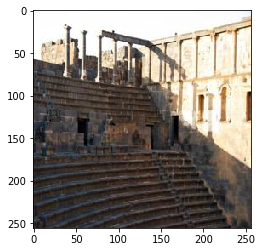

In [9]:
img = plt.imread(f'{PATH}valid/amphitheater/{files[2]}')
plt.imshow(img);
img.shape

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [10]:
# this is a pre-trained network based on the imagenet
arch = resnet18
arch

<function torchvision.models.resnet.resnet18(pretrained=False, **kwargs)>

In [25]:
#tfms_from_model??
#Learner??
#ImageClassifierData??

# tfms_from_model is a data augmentation function
# it's already doing a great job, but it'd be better if it does some random rotations too (e.g., 22 deg clockwise)
# may require some computation??

In [11]:
tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)

# how many CPUs will work for the image pre-processing?
num_workers = 8

# this determines GPU MEM size
batch_size = 512

# with Places2, this takes a while
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), 
                                      bs = batch_size, num_workers = num_workers)
data

In [12]:
# the number of training & validation images
# check the number of images in the data directory using the command: tree | wc -l
[len(data.trn_y), len(data.val_y), batch_size]

# The numbers are, 1803460 images to train, 36500 images to validate
# ~5000 images for each category

[1803460, 36500, 512]

### Take the pretrained resnet, and customize

In [52]:
# Places 2, GPU MEM notes -- what is the bottleneck here?
# image size is 224 for all

# cpu cores: 9 (num_worker=8), batch_size: 64, iterations 28180, GPU Mem 1035 Mb, 2.01 it/s, GPU is not fully utilized 
# cpu cores: 9 (num_worker=8), batch_size: 128, iterations 14090, GPU Mem 1823 Mb, 1.36 it/s, GPU is not fully utilized

# cpu cores: 17 (num_worker=16), batch_size: 64, iterations 28180, GPU Mem 1035 Mb, 3.60 it/s
# cpu cores: 17 (num_worker=16), batch_size: 128, iterations 14090, GPU Mem 1824 Mb, 2.02 it/s
# cpu cores: 17 (num_worker=16), batch_size: 256, iterations 7045, GPU Mem 3409 Mb, 1.00 it/s
# cpu cores: 17 (num_worker=16), batch_size: 640, iterations 2820, GPU Mem 7329 Mb, 2 s/it
# cpu cores: 17 (num_worker=16), batch_size: 768, iterations 2349, GPU Mem 8754 Mb, 4 s/it


# cpu cores: 17 (num_worker=16), batch_size: 256, iterations 7045, GPU Mem 3409 Mb, 1.00 it/s
#  --> 1 hr 50 min

# cpu cores: 17 (num_worker=16), batch_size: 512, iterations 3523, GPU Mem 6414 Mb, 1.00 it/s
#  --> 1 hr 50 min



In [13]:
# actually, this step is to get activation for all the images, so will run just once
# this makes some tmp files in the tmp directory

torch.cuda.empty_cache()

# This seems to take about 2 hours regardless

# It took 1 hour 42 minutes

learn = ConvLearner.pretrained(arch, data, precompute=True)
learn

100%|██████████| 72/72 [02:01<00:00,  1.69s/it]


Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=365, bias=True)
  (7): LogSoftmax()
)

In [14]:
# learning rate finder

# this took 1 hour 17 minutes

lrf=learn.lr_find()

 93%|█████████▎| 3282/3523 [1:17:22<05:40,  1.41s/it, loss=13.7]  

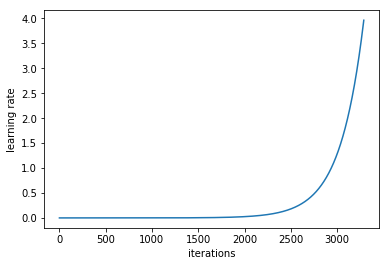

In [15]:
learn.sched.plot_lr()

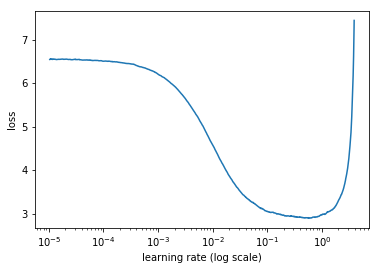

In [16]:
learn.sched.plot()

The loss is still clearly improving around lr=0.05, so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

In [20]:
# run one epoch, using the learning rate .05, selected based on the above plot

# this is based on pre-computed activation, so should be fast...??

# GPU is not working hard --- 

# 1 pre-computed epoch took 42 minutes

learn.fit(.05, 1)

  0%|          | 0/3523 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                      
    0      2.613782   2.367934   0.40189   



[array([2.36793]), 0.40189041091318]

### After one epoch, it's already doing 40%

https://arxiv.org/pdf/1707.01629.pdf

Table 3: Comparison with state-of-theart CNNs on Places365-Standard dataset.
10 crops validation accuracy rate (%) on validation set.

Model / Size / top-1 acc. / top-5 acc.

AlexNet [24] 223 MB 53.17 82.89

GoogleLeNet [24] 44 MB 53.63 83.88

VGG-16 [24] 518 MB 55.24 84.91

ResNet-152 [24] 226 MB 54.74 85.08

ResNeXt-101 [3] 165 MB 56.21 86.25

CRU-Net-116 [3] 163 MB 56.60 86.55

DPN-92 (32 × 3d) 138 MB 56.84 86.69

In [23]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.4035342465753425

little bit better but not much different ... so let's move on

In [24]:
learn.precompute=False

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

In [25]:
learn.fit(.05,  3,  cycle_len=1)

  0%|          | 0/3523 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                         
    0      2.528767   2.30864    0.415589  
    1      2.504014   2.290695   0.419534                         
    2      2.475495   2.276569   0.42137                          



[array([2.27657]), 0.4213698630071666]

In [21]:
# let's repeat another epoch

learn.fit(.05, 1)



 15%|█▍        | 520/3523 [13:19<1:16:59,  1.54s/it, loss=2.59]

KeyboardInterrupt: 

 15%|█▍        | 520/3523 [13:30<1:17:57,  1.56s/it, loss=2.59]

## figure out a way to save and load the model without error

Try with CIFAR-10 until perfect, and then apply it here. 

http://forums.fast.ai/t/loading-a-saved-model/7865

In [17]:
mod_mod = arch(True)
mod_mod

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [18]:
mod_mod = nn.Sequential(*children(mod_mod)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())
mod_mod

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [28]:
learn = ConvLearner.from_model_data(mod_mod, data)
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [30]:
learn.freeze_to(-4)

In [222]:
[mod_mod[-1].trainable, mod_mod[-2].trainable, mod_mod[-3].trainable, 
 mod_mod[-4].trainable, mod_mod[-5].trainable]

[True, True, True, True, False]

In [36]:
lrf=learn.lr_find()

 65%|██████▍   | 233/360 [01:15<00:41,  3.08it/s, loss=0.322] 

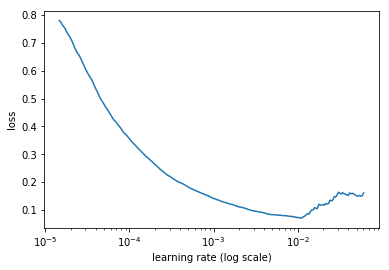

In [39]:
learn.sched.plot()

In [41]:
learn.fit(0.01, 2)

  8%|▊         | 27/360 [00:09<01:57,  2.83it/s, loss=0.751]
epoch      trn_loss   val_loss   accuracy                    
    0      0.204002   0.16309    0.982     
    1      0.167655   0.153516   0.9815                      



[array([0.15352]), 0.9815]

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

In [132]:
# This is the label for a val data
# press tab to look at what other things the data class has
[len(data.val_y), data.val_y]

[2000, array([0, 0, 0, ..., 1, 1, 1])]

In [43]:
data.classes

['cats', 'dogs']

In [44]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [45]:
log_preds[:10]

array([[   0.     ,  -41.24478],
       [   0.     ,  -52.92077],
       [   0.     ,  -89.26395],
       [   0.     , -119.05429],
       [   0.     ,  -42.17303],
       [   0.     ,  -71.02538],
       [   0.     ,  -54.0239 ],
       [   0.     ,  -71.12198],
       [   0.     ,  -95.05789],
       [   0.     ,  -37.80942]], dtype=float32)

In [46]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
probs

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [47]:
[sum((preds == data.val_y)==False), sum((preds == data.val_y)==False)/len(preds)]

[37, 0.0185]

# OK, let's examine the correct/incorrect pictures

In [277]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 10, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title, rows=2):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=rows, titles=title_probs, figsize=(16,8))        

Correctly classified


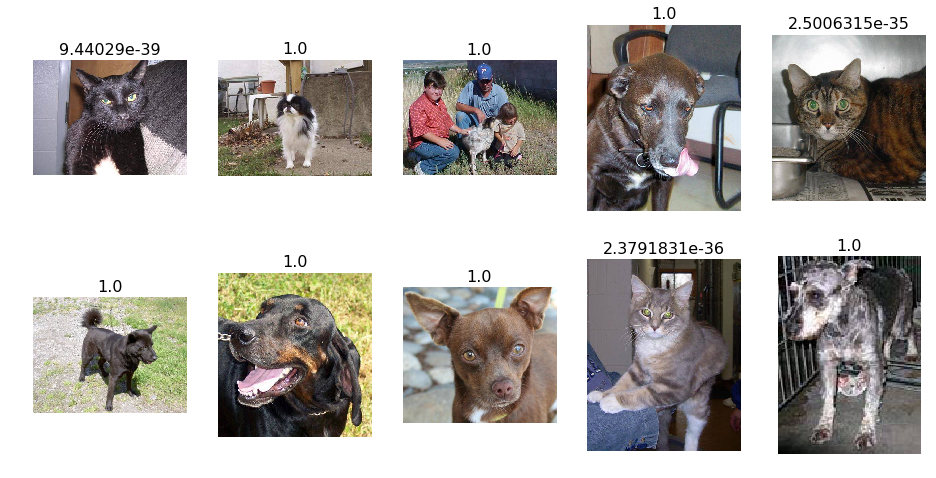

In [278]:
# 1. A few correct labels at random --> both cat and dogs
# number close to 0 --> cats
# number close to 1 --> dogs
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


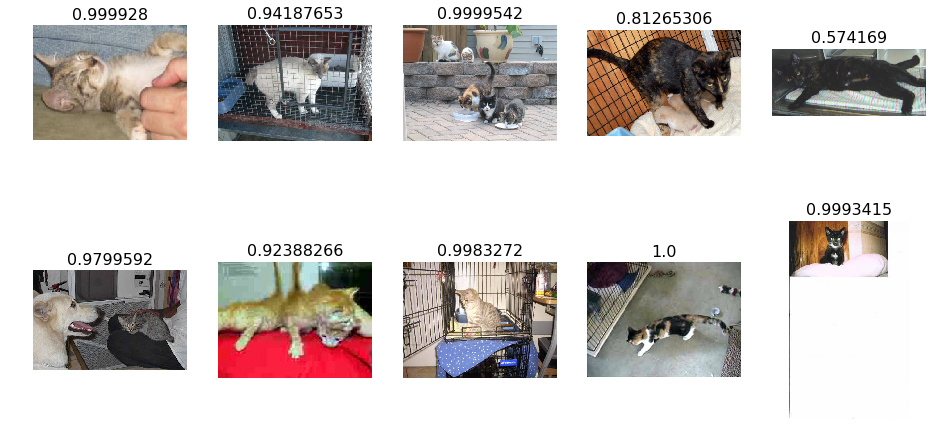

In [279]:
# 2. A few incorrect labels at random
# 0: cat, 1: dog
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [280]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:10]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


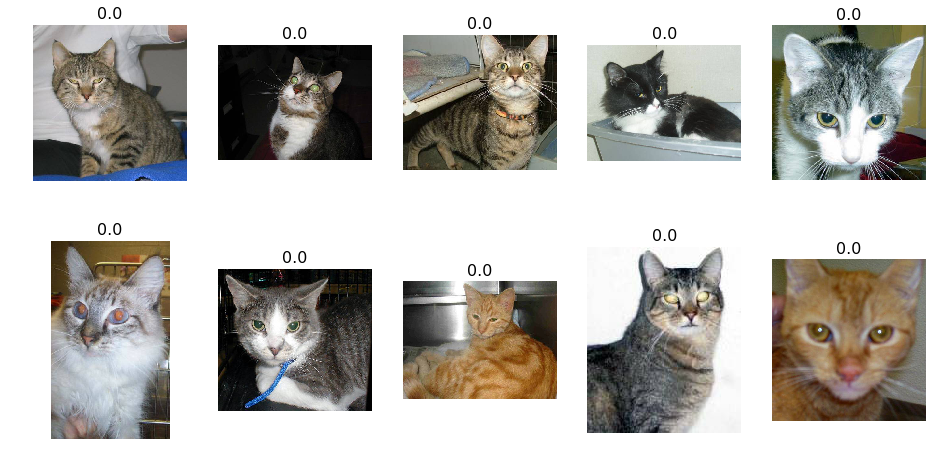

In [281]:
# mask 0 --> cats
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


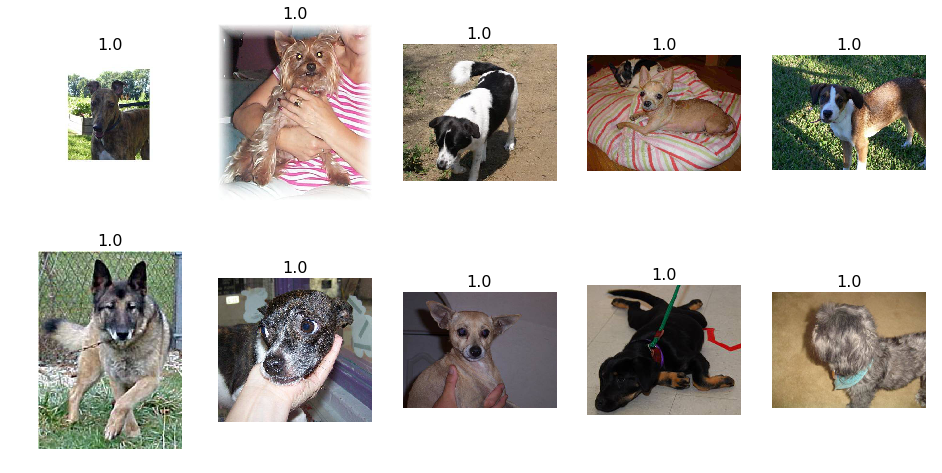

In [282]:
# mask 1 --> dogs
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


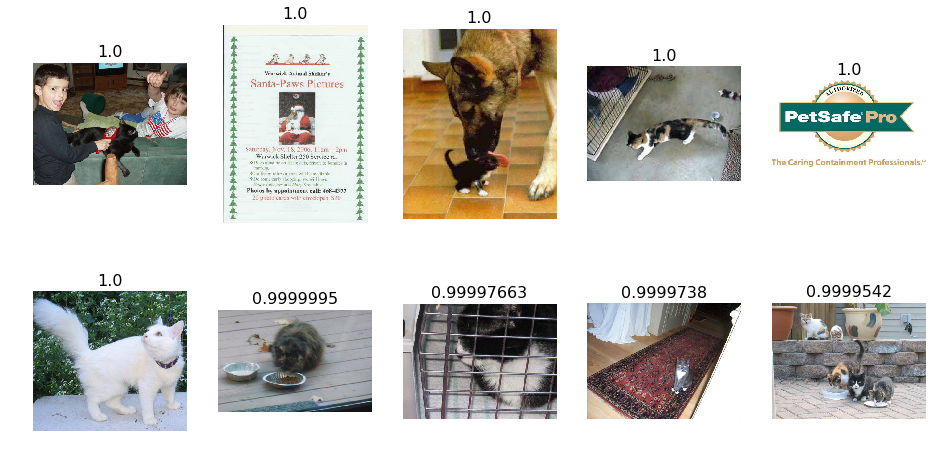

In [283]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


ValueError: num must be 1 <= num <= 4, not 5

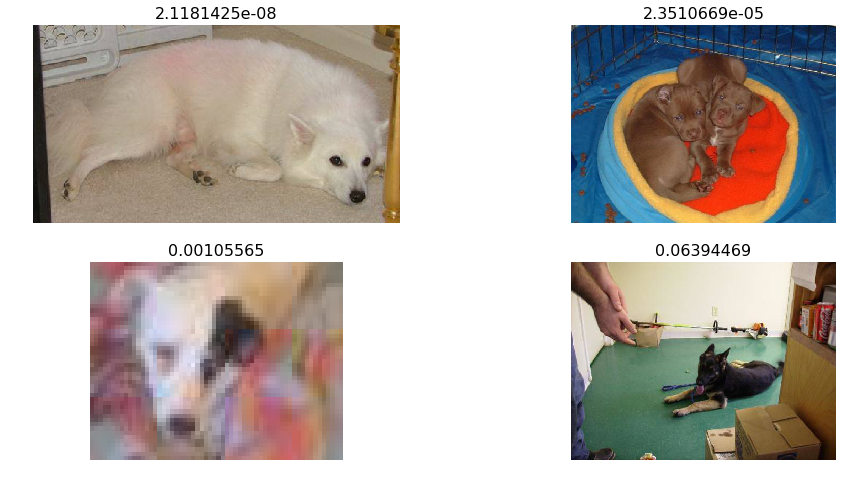

In [284]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


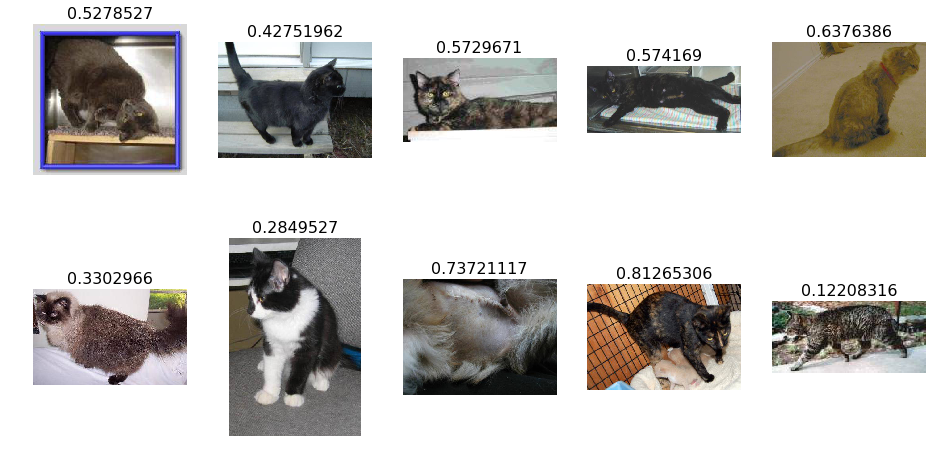

In [61]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:10]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Class activation map!!

In [223]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [224]:
# load the raw data from the validation images (64 is the batch size)
x,y = next(iter(data.val_dl))

In [225]:
x


( 0 , 0 ,.,.) = 
 -1.6309 -1.6297 -1.6622  ...   0.4793  0.5952  0.5818
 -1.7009 -1.6547 -1.6512  ...   0.5378  0.6375  0.6202
 -1.7725 -1.7528 -1.7290  ...   0.6673  0.6758  0.5900
           ...             ⋱             ...          
 -1.2727 -1.0752 -0.8977  ...  -0.2573 -0.2784 -0.3553
 -1.3736 -1.1243 -1.0081  ...  -0.2761 -0.3048 -0.3520
 -1.4263 -1.1358 -1.0836  ...  -0.3519 -0.3877 -0.3978

( 0 , 1 ,.,.) = 
 -1.8523 -1.8640 -1.8206  ...  -0.0808  0.0412  0.0415
 -1.7646 -1.7232 -1.7320  ...  -0.0210  0.0845  0.0808
 -1.6744 -1.6266 -1.7342  ...   0.1114  0.1235  0.0564
           ...             ⋱             ...          
 -1.2522 -1.0407 -0.8355  ...   0.5787  0.5948  0.5895
 -1.3565 -1.0991 -0.9631  ...   0.6050  0.6168  0.6134
 -1.4150 -1.1170 -1.0422  ...   0.5811  0.5910  0.6316

( 0 , 2 ,.,.) = 
 -1.5846 -1.5257 -1.5075  ...  -0.0325  0.1225  0.1602
 -1.5741 -1.4389 -1.4436  ...   0.0270  0.1656  0.1994
 -1.4815 -1.4102 -1.4729  ...   0.1710  0.2061  0.1718
           

In [263]:
# x is a image, 3x224x224
# y is the label
xx,yy = x[None,1], y[None,1]
[xx, yy]

[
 ( 0 , 0 ,.,.) = 
   1.3924e+00  1.3924e+00  1.3767e+00  ...   1.3410e+00  1.3410e+00  1.3410e+00
   1.3743e+00  1.3743e+00  1.3435e+00  ...   1.3236e+00  1.3236e+00  1.3236e+00
   1.3386e+00  1.3386e+00  1.3094e+00  ...   1.3052e+00  1.3052e+00  1.3052e+00
                  ...                   ⋱                   ...                
   3.2887e-01  1.7935e-01  2.7379e-01  ...  -6.0759e-01 -5.7758e-01 -5.7745e-01
   5.7716e-01  4.1535e-01  5.1432e-01  ...  -6.0585e-01 -5.5819e-01 -5.4363e-01
   8.0712e-01  6.2773e-01  6.9434e-01  ...  -6.0242e-01 -5.2587e-01 -5.2560e-01
 
 ( 0 , 1 ,.,.) = 
   1.6054e+00  1.6054e+00  1.5894e+00  ...   1.5004e+00  1.5004e+00  1.5004e+00
   1.5870e+00  1.5870e+00  1.5555e+00  ...   1.4826e+00  1.4826e+00  1.4826e+00
   1.5505e+00  1.5505e+00  1.5206e+00  ...   1.4638e+00  1.4638e+00  1.4638e+00
                  ...                   ⋱                   ...                
   3.9670e-01  2.4372e-01  2.9382e-01  ...  -5.7922e-01 -5.4854e-01 -5.4841e-01


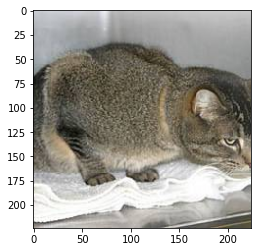

In [264]:
dx = data.val_ds.denorm(xx)[0]
plt.imshow(dx);

In [265]:
sfs = [SaveFeatures(o) for o in [mod_mod[-7], mod_mod[-6], mod_mod[-5], mod_mod[-4]]]
sfs

In [266]:
# category inference based on the image (xx)
%time py = mod_mod(Variable(xx.cuda()))
py

CPU times: user 5.37 ms, sys: 208 µs, total: 5.57 ms
Wall time: 5.04 ms


Variable containing:
  0.0000 -52.9208
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [267]:
Variable(xx.cuda())

Variable containing:
( 0 , 0 ,.,.) = 
  1.3924e+00  1.3924e+00  1.3767e+00  ...   1.3410e+00  1.3410e+00  1.3410e+00
  1.3743e+00  1.3743e+00  1.3435e+00  ...   1.3236e+00  1.3236e+00  1.3236e+00
  1.3386e+00  1.3386e+00  1.3094e+00  ...   1.3052e+00  1.3052e+00  1.3052e+00
                 ...                   ⋱                   ...                
  3.2887e-01  1.7935e-01  2.7379e-01  ...  -6.0759e-01 -5.7758e-01 -5.7745e-01
  5.7716e-01  4.1535e-01  5.1432e-01  ...  -6.0585e-01 -5.5819e-01 -5.4363e-01
  8.0712e-01  6.2773e-01  6.9434e-01  ...  -6.0242e-01 -5.2587e-01 -5.2560e-01

( 0 , 1 ,.,.) = 
  1.6054e+00  1.6054e+00  1.5894e+00  ...   1.5004e+00  1.5004e+00  1.5004e+00
  1.5870e+00  1.5870e+00  1.5555e+00  ...   1.4826e+00  1.4826e+00  1.4826e+00
  1.5505e+00  1.5505e+00  1.5206e+00  ...   1.4638e+00  1.4638e+00  1.4638e+00
                 ...                   ⋱                   ...                
  3.9670e-01  2.4372e-01  2.9382e-01  ...  -5.7922e-01 -5.4854e-01 -5.4841e

In [268]:
# basically imitating the final layer:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [232]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

Compare the parameters
![ResNet layers](http://tvmlang.org/images/release/resnet_rasp.png)

In [233]:
# sfs[3] means, we will only look at the final 7x7 grid ... 
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [234]:
np.rollaxis(feat,0,3).shape

(7, 7, 2)

In [235]:
f2=np.dot(np.rollaxis(feat,0,3), py)

In [236]:
# simple scaling from 0 to 1
f2-=f2.min()
f2/=f2.max()

# thresholding
f2[f2 < .3] = 0

f2

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.32711, 0.39504, 0.48744, 0.39501],
       [0.     , 0.     , 0.     , 0.39686, 0.59749, 0.80396, 0.64921],
       [0.     , 0.     , 0.     , 0.38832, 0.70303, 1.     , 0.81173],
       [0.     , 0.     , 0.     , 0.30838, 0.60536, 0.8808 , 0.71888],
       [0.     , 0.     , 0.     , 0.     , 0.30431, 0.46705, 0.39087]], dtype=float32)

/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


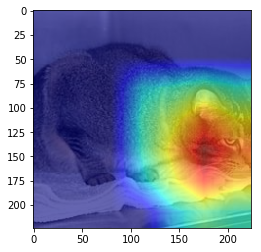

In [237]:
# where is the cat??
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.6, cmap='jet');

# Repeat the above

In [238]:
sfs = [SaveFeatures(o) for o in [mod_mod[-7], mod_mod[-6], mod_mod[-5], mod_mod[-4]]]
sfs

In [239]:
[o.features for o in sfs]

[None, None, None, None]

In [243]:
%time py = mod_mod(Variable(xx.cuda()))
py

CPU times: user 5.44 ms, sys: 629 µs, total: 6.07 ms
Wall time: 5.44 ms


Variable containing:
  0.0000 -52.9208
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [244]:
[o.features for o in sfs]

[Variable containing:
 ( 0 , 0 ,.,.) = 
   0.1404  0.2895  0.0898  ...   0.1442  0.2455  0.5168
   0.0590  0.0000  0.0000  ...   0.0000  0.0000  0.0888
   0.1072  0.0000  0.0000  ...   0.0000  0.0000  0.1488
            ...             ⋱             ...          
   0.3324  0.0000  0.0000  ...   0.0000  0.1197  0.3803
   0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
   0.2224  0.0000  0.0000  ...   0.0722  0.4398  0.3361
 
 ( 0 , 1 ,.,.) = 
   0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  ...   0.1029  0.2629  0.0453
   0.2250  0.3214  0.0959  ...   0.0000  0.1816  0.0165
            ...             ⋱             ...          
   0.2215  0.3727  0.4150  ...   0.1436  0.0000  0.0000
   0.3600  0.3346  0.2122  ...   0.2306  0.3995  0.2791
   0.2445  0.0000  0.0000  ...   0.4461  0.5668  0.5939
 
 ( 0 , 2 ,.,.) = 
   0.3150  0.0000  0.0000  ...   0.0000  0.0236  0.5377
   0.3332  0.0000  0.0000  ...   0.1538  0.9373  0.2315
   0.0188  0.0000  0.000

In [269]:
idx = most_by_correct(0, True)
ii = 0
xx, yy = data.val_ds.get1item(idx[ii])
txx = torch.from_numpy(xx).unsqueeze_(0)
py = mod_mod(Variable(txx.cuda()))
[o.features.shape for o in sfs]
py = np.exp(to_np(py)[0])
feat = np.maximum(0,to_np(sfs[3].features[0]))
f2 = np.dot(np.rollaxis(feat,0,3), py)
f2.shape

(7, 7)

In [288]:
def plot_cam_with_title(idx, rows=2, figsize=(16,8)):
    fig = plt.figure(figsize=figsize)
    for ii in range(len(idx)):
        sp = fig.add_subplot(rows, len(idx)//rows, ii+1)
        sp.axis('Off')
        sp.set_title(probs[idx[ii]], fontsize=16)
        
        # display the input (transformed image)
        xx, yy = data.val_ds.get1item(idx[ii])
        img = data.val_ds.denorm(xx)[0]
        plt.imshow(img)
        
        # generate & overlay the heatmap
        txx = torch.from_numpy(xx).unsqueeze_(0)
        py = mod_mod(Variable(txx.cuda()))
        py = np.exp(to_np(py)[0])
        feat = np.maximum(0,to_np(sfs[3].features[0]))
        f2 = np.dot(np.rollaxis(feat,0,3), py)
        # simple scaling from 0 to 1
        f2-=f2.min()
        f2/=f2.max()
        # thresholding
        f2[f2 < .3] = 0
        plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.6, cmap='jet');

In [289]:
most_by_correct(0, True)

array([318, 323, 921,  39, 314, 759, 763, 920, 771, 294])

/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


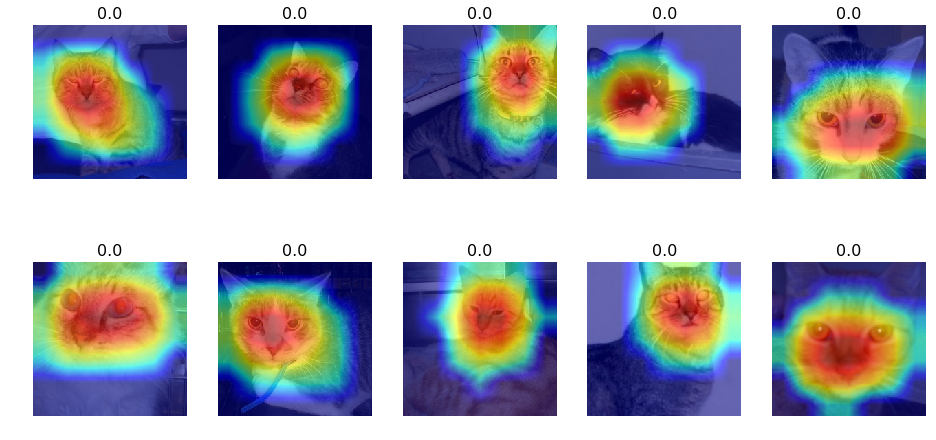

In [290]:
plot_cam_with_title(most_by_correct(0, True))

/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


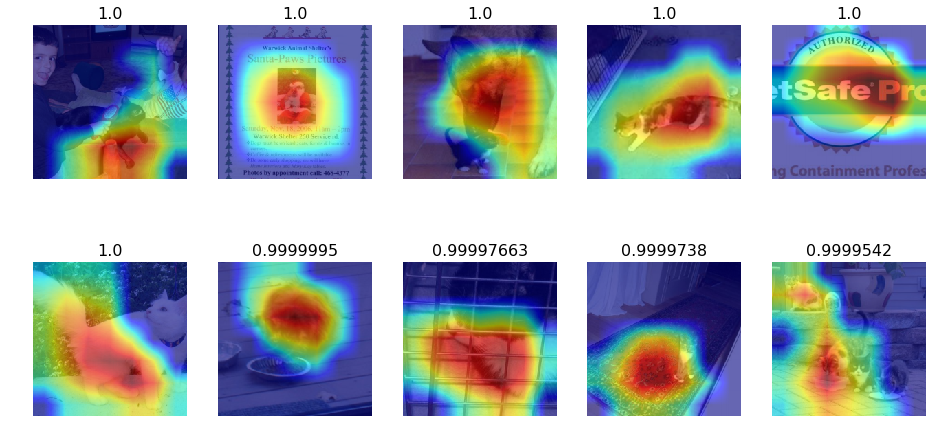

In [292]:
plot_cam_with_title(most_by_correct(0, False))

/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


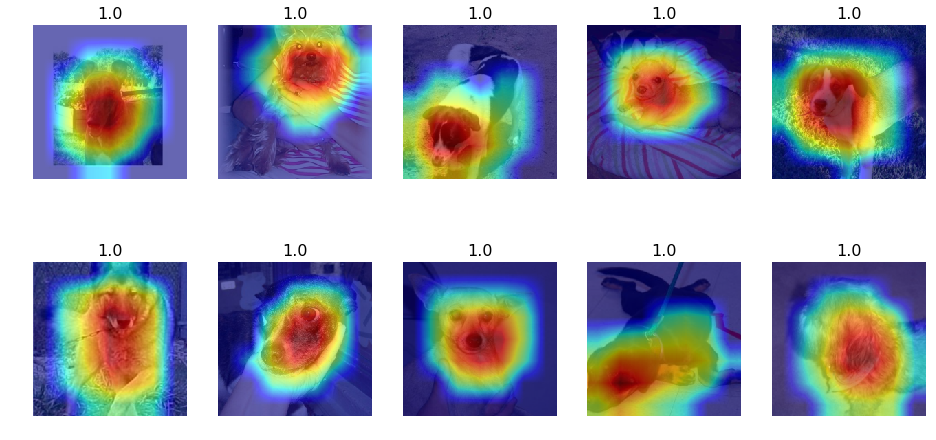

In [291]:
plot_cam_with_title(most_by_correct(1, True))

/home/kywch/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


ValueError: num must be 1 <= num <= 4, not 5

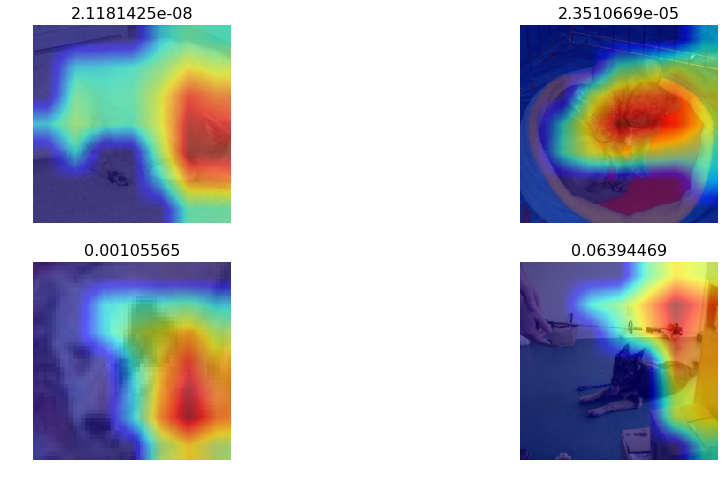

In [293]:
plot_cam_with_title(most_by_correct(1, False))